Looking at the results of neutrino energy resonctruction from "EnRec.ipynb"

In [1]:
from I3Tray import *
from icecube import icetray, dataio, dataclasses
from icecube import phys_services
from icecube import tableio, hdfwriter
import numpy as np
import scipy
import matplotlib as mpl
import pylab
import matplotlib.pyplot as plt
import copy
import math
import sys, tables
from scipy.optimize import curve_fit
import glob
import os
from icecube import NewNuFlux
from icecube.icetray import I3Units
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

from icecube import gulliver,gulliver_modules,improvedLinefit,MuonGun, simclasses,paraboloid, dipolefit
from icecube import clast, cscd_llh, fill_ratio, tensor_of_inertia

from icecube.weighting.fluxes import Hoerandel5,GaisserH3a
from icecube.weighting import weighting

conventional = NewNuFlux.makeFlux("honda2006")
conventional.knee_reweighting_model = "gaisserH3a_elbert"

sys.path.append("/home/kevin/softwares/")
import dashi
dashi.visual()

import warnings
warnings.filterwarnings('ignore')

sys.path.append("/data/user/kevin/softwares/IceCubeMinDist/")
from ICMinDist import minDistDet

In [2]:
%matplotlib inline

Class of datasets which we load events' inforamtion in:

In [3]:
class dataset:
    def __init__(self):
        self.zenith=np.array([])
        self.relevant_energy=np.array([])
        self.ptype=np.array([])
        self.MCenergy=np.array([])
        self.MCMu=np.array([])
        self.MCzenith=np.array([])
        self.OneWeight=np.array([])
        self.weight=np.array([])
        self.MCneutrinoEnergy=np.array([])
        self.MCPrimary=np.array([])
        self.MCCascade=np.array([])
        self.totQ=np.array([])
        self.decisionFunction=np.array([])
        self.weight1yr=np.array([])
        self.MuonEnergy_splined_millipede=np.array([])
        self.cascadeEnergy_millipede=np.array([])
        self.dEdx_millipede=np.array([])
        self.px=np.array([])
        self.py=np.array([])
        self.pz=np.array([])
        self.pcx=np.array([])
        self.pcy=np.array([])
        self.pcz=np.array([])
        self.NeutrinoEnergy_splined_millipede=np.array([])
        self.MCTrue=np.array([])
        self.MCTrue_polygon=np.array([])
        self.NeutrinoEnergy_adaboost=np.array([])

Importing processed and weighted NuFSGen data:

In [4]:
count=0
file_list=["/data/user/kevin/sterile/startingTrack/data/compare/NuSelection_NuFSGen_LE_L5_st90.dat",
           "/data/user/kevin/sterile/startingTrack/data/compare/NuSelection_NuFSGen_HE_L5_st90.dat"]

nufsgen_st = dataset()

for file in file_list:
    #f=glob.glob(file)
    t=np.loadtxt(file)
    count+=1
    nufsgen_st.weight1yr=np.append(nufsgen_st.weight1yr,t[:,4])
    nufsgen_st.MCzenith=np.append(nufsgen_st.MCzenith,t[:,1])
    nufsgen_st.MCPrimary=np.append(nufsgen_st.MCPrimary,t[:,3])
    nufsgen_st.MCCascade=np.append(nufsgen_st.MCCascade,t[:,8])
    nufsgen_st.zenith=np.append(nufsgen_st.zenith,t[:,6])
    #nufsgen_st.relevant_energy=np.append(nufsgen_st.relevant_energy,t[:,5])
    nufsgen_st.MCneutrinoEnergy=np.append(nufsgen_st.MCneutrinoEnergy,t[:,9])
    nufsgen_st.ptype=np.append(nufsgen_st.ptype,t[:,0])
    nufsgen_st.MCTrue=np.append(nufsgen_st.MCTrue,t[:,10])
    nufsgen_st.px=np.append(nufsgen_st.px,t[:,11])
    nufsgen_st.py=np.append(nufsgen_st.py,t[:,12])
    nufsgen_st.pz=np.append(nufsgen_st.pz,t[:,13])
    nufsgen_st.pcx=np.append(nufsgen_st.pcx,t[:,27])
    nufsgen_st.pcy=np.append(nufsgen_st.pcy,t[:,28])
    nufsgen_st.pcz=np.append(nufsgen_st.pcz,t[:,29])
    nufsgen_st.MuonEnergy_splined_millipede=np.append(nufsgen_st.MuonEnergy_splined_millipede,t[:,24])
    nufsgen_st.dEdx_millipede=np.append(nufsgen_st.dEdx_millipede,t[:,23])
    nufsgen_st.NeutrinoEnergy_splined_millipede=np.append(nufsgen_st.NeutrinoEnergy_splined_millipede,t[:,25])
    nufsgen_st.cascadeEnergy_millipede=np.append(nufsgen_st.cascadeEnergy_millipede,t[:,26])
    nufsgen_st.NeutrinoEnergy_adaboost=np.append(nufsgen_st.NeutrinoEnergy_adaboost,t[:,30])
    print(str(count)+' nufsgen files loaded')
    del t

1 nufsgen files loaded
2 nufsgen files loaded


Calculating missing properties:

In [5]:
# Cascade minDist
nufsgen_st.minDistDetCas = np.zeros_like(nufsgen_st.px)
for i in range(len(nufsgen_st.minDistDetCas)):
    nufsgen_st.minDistDetCas[i] = minDistDet(nufsgen_st.pcx[i], nufsgen_st.pcy[i],nufsgen_st.pcz[i])

In [6]:
# Cascade True minDist
nufsgen_st.minDistDet=np.zeros_like(nufsgen_st.px)
for i in range(len(nufsgen_st.minDistDet)):
    nufsgen_st.minDistDet[i] = minDistDet(nufsgen_st.px[i], nufsgen_st.py[i],nufsgen_st.pz[i])

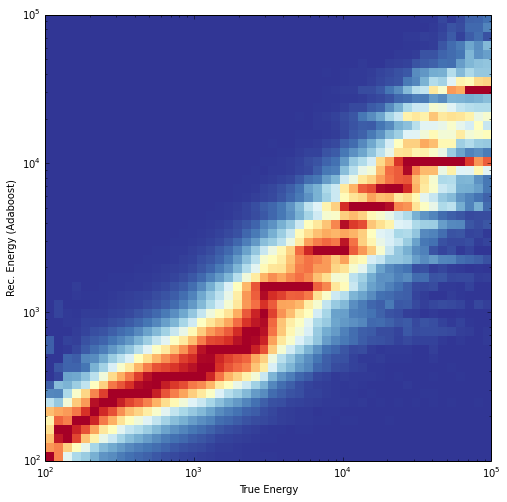

In [11]:
fig, ax = plt.subplots(figsize = [8, 8])

bins = np.logspace(2, 5, 51)
xbins = bins
ybins = bins

# only strarting tracks, i.e. neutrinos
Filter = lambda dset:(dset.minDistDet < 0)
filter = Filter(nufsgen_st)

hist = dashi.factory.hist2d((nufsgen_st.MCneutrinoEnergy[filter],
                             nufsgen_st.NeutrinoEnergy_adaboost[filter]),
                             bins=(xbins, ybins))

# Normalize vertically
for i in range(len(hist.bincontent)):
    den = max(hist.bincontent[i])
    for j in range(len(hist.bincontent[i])):
        hist.bincontent[i][j] /= (den * 1.)

hist.imshow(norm=mpl.colors.Normalize(), cmap = mpl.cm.RdYlBu_r)
plt.loglog()
plt.xlabel('True Energy')
plt.ylabel('Rec. Energy (Adaboost)')

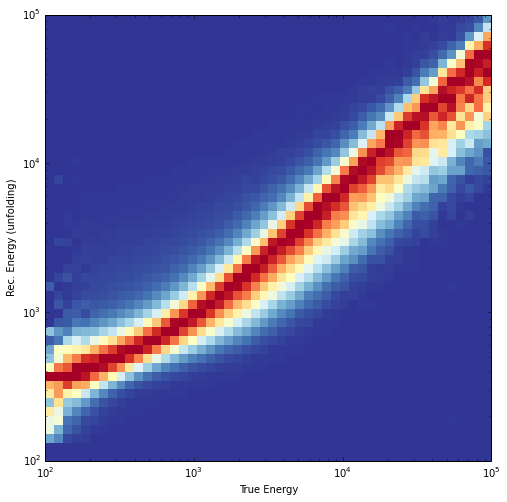

In [13]:
fig, ax = plt.subplots(figsize = [8, 8])

bins = np.logspace(2, 5, 51)
xbins = bins
ybins = bins

# only strarting tracks, i.e. neutrinos
Filter = lambda dset:(dset.minDistDet < 0)
filter = Filter(nufsgen_st)

hist = dashi.factory.hist2d((nufsgen_st.MCneutrinoEnergy[filter],
                             nufsgen_st.NeutrinoEnergy_splined_millipede[filter]),
                             bins=(xbins, ybins))

# Normalize vertically
for i in range(len(hist.bincontent)):
    den = max(hist.bincontent[i])
    for j in range(len(hist.bincontent[i])):
        hist.bincontent[i][j] /= (den * 1.)

hist.imshow(norm=mpl.colors.Normalize(), cmap = mpl.cm.RdYlBu_r)
plt.loglog()
plt.xlabel('True Energy')
plt.ylabel('Rec. Energy (unfolding)')

### resolution

To compare the two results better, we can look at the energy resolution vs. energy.

In [24]:
def resolution(true, rec, weights, bins):
    """
    This function will give us an arrray of resolution vs.
    log of energy.
    true: true energy
    rec: reconstructed energy
    weighte: event weights
    bins: log bins
    """
    res = np.array([])
    y = np.log10(rec)
    for i in range(len(bins) - 1):
        filter = (true >= bins[i]) &\
                 (true < bins[i + 1]) &\
                 (rec < 1e6) &\
                 (rec > 1e2)
        if(len(rec[filter]) > 0):
            stripe_avg = np.average(y[filter], weights=weights[filter])
            res_tmp = np.sqrt(sum(np.multiply(np.power(np.subtract(y[filter], stripe_avg), 2),
                                              weights[filter])) / sum(weights[filter]))
        else:
            res_tmp = 0
        res = np.append(res, res_tmp)
    return res

[]

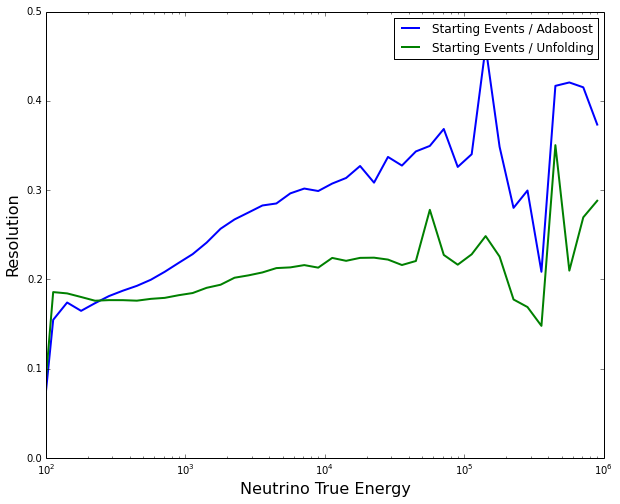

In [32]:
bins = np.logspace(1, 6, 51)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

# only strarting tracks, i.e. neutrinos
Filter = lambda dset:(dset.minDistDet < 0)
filter = Filter(nufsgen_st)

res_ada = resolution(nufsgen_st.MCneutrinoEnergy[filter],
                     nufsgen_st.NeutrinoEnergy_adaboost[filter],
                     weights=nufsgen_st.weight1yr[filter],
                     bins=bins)

res_unfolding = resolution(nufsgen_st.MCneutrinoEnergy[filter],
                           nufsgen_st.NeutrinoEnergy_splined_millipede[filter],
                           weights=nufsgen_st.weight1yr[filter],
                           bins=bins)

# plotting
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.plot(bins_center, res_ada,
        linewidth=2,
        label='Starting Events / Adaboost')

ax.plot(bins_center, res_unfolding,
        linewidth=2,
        label='Starting Events / Unfolding')

plt.xlim(1e2, 1e6)
plt.legend(fontsize=12)
plt.xlabel('Neutrino True Energy', fontsize=16)
plt.ylabel('Resolution', fontsize=16)
plt.semilogx()

Looking at the cascade reconstructed energy

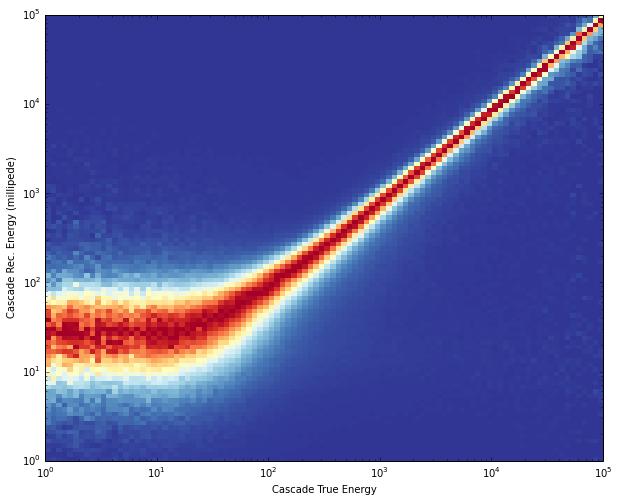

In [35]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

bins = np.logspace(0, 5, 101)
xbins = bins
ybins = bins

# only strarting tracks, i.e. neutrinos
Filter = lambda dset:(dset.minDistDet < 0)
filter = Filter(nufsgen_st)

hist = dashi.factory.hist2d((nufsgen_st.MCCascade[filter],
                             nufsgen_st.cascadeEnergy_millipede[filter]),
                             bins=(xbins, ybins))

for i in range(len(hist.bincontent)):
    # den=sum(hist.bincontent[i])
    den = max(hist.bincontent[i])
    for j in range(len(hist.bincontent[i])):
        hist.bincontent[i][j] /= (den * 1.)


hist.imshow(norm=mpl.colors.Normalize(), cmap=mpl.cm.RdYlBu_r)

plt.loglog()
plt.xlabel('Cascade True Energy')
plt.ylabel('Cascade Rec. Energy (millipede)')

Cascade energy resolution:

[]

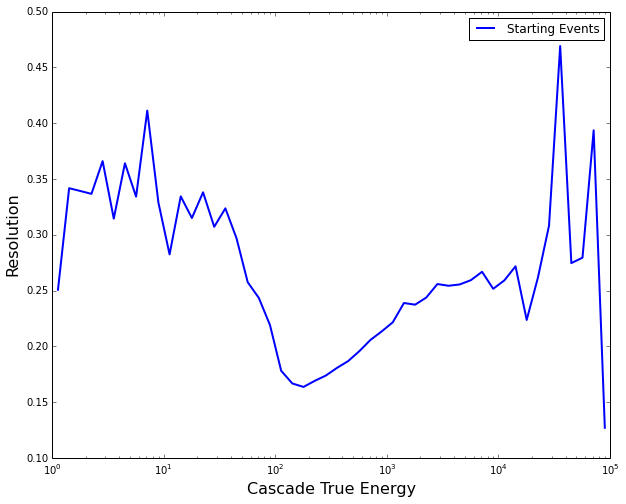

In [39]:
bins = np.logspace(0, 5, 51)
bins_center = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

# only strarting tracks, i.e. neutrinos
Filter = lambda dset:(dset.minDistDet < 0)
filter = Filter(nufsgen_st)

res = resolution(nufsgen_st.MCCascade[filter],
                     nufsgen_st.cascadeEnergy_millipede[filter],
                     weights=nufsgen_st.weight1yr[filter],
                     bins=bins)

# plotting
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.plot(bins_center, res,
        linewidth=2,
        label='Starting Events')

plt.xlim(1e0, 1e5)
plt.legend(fontsize=12)
plt.xlabel('Cascade True Energy', fontsize=16)
plt.ylabel('Resolution', fontsize=16)
plt.semilogx()

Energy and zenith angle distributions for starting and through-going events:

[]

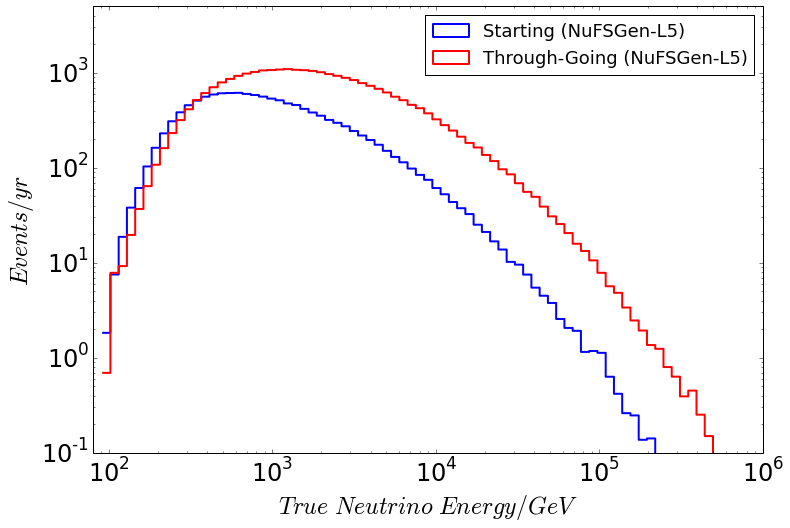

In [203]:
fig = plt.figure(figsize=(12,8))
bins=np.logspace(1,6,100)


Filter = lambda dset:(dset.relevant_energy>2e2)&(dset.relevant_energy<8e4)
filterST=Filter(nufsgen_st)

Filter = lambda dset:(dset.relevant_energy>1e2)&(dset.relevant_energy<2e4)
filterTG=Filter(nufsgen_tg)

bins_center = [ (bins[i]+bins[i+1])/2 for i in range(len(bins)-1) ]
plt.hist(nufsgen_st.MCneutrinoEnergy[filterST],weights=nufsgen_st.weight1yr[filterST],bins=bins,histtype='step',
         label='Starting (NuFSGen-L5)',color='b',linewidth=2)
plt.hist(nufsgen_tg.MCneutrinoEnergy[filterTG],weights=nufsgen_tg.weight1yr[filterTG],bins=bins,histtype='step',
        label='Through-Going (NuFSGen-L5)',color='r',linewidth=2)
plt.xlim(8e1,1e6)
plt.ylim(1e-1,5e3)
plt.legend(fontsize=18)
plt.xlabel(r'$True\ Neutrino\ Energy/GeV$',fontsize=24)
plt.ylabel(r'$Events/yr$',fontsize=24)
plt.tick_params(axis='both',which='major',labelsize=24)
plt.loglog()

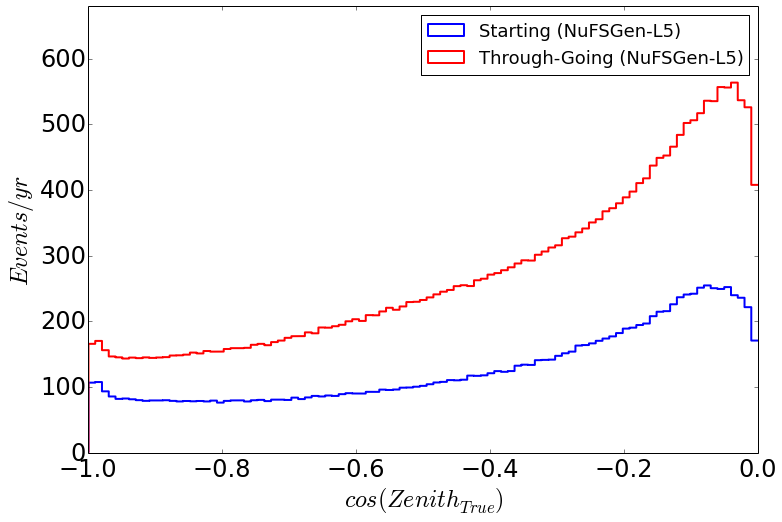

In [220]:
fig = plt.figure(figsize=(12,8))
bins=np.linspace(-1,0,100)

Filter = lambda dset:(dset.relevant_energy>2e2)&(dset.relevant_energy<8e4)
filterST=Filter(nufsgen_st)

Filter = lambda dset:(dset.relevant_energy>1e2)&(dset.relevant_energy<2e4)
filterTG=Filter(nufsgen_tg)

bins_center = [ (bins[i]+bins[i+1])/2 for i in range(len(bins)-1) ]
plt.hist(nufsgen_st.MCzenith[filterST],weights=nufsgen_st.weight1yr[filterST],bins=bins,histtype='step',
         label='Starting (NuFSGen-L5)',color='b',linewidth=2)
plt.hist(nufsgen_tg.MCzenith[filterTG],weights=nufsgen_tg.weight1yr[filterTG],bins=bins,histtype='step',
        label='Through-Going (NuFSGen-L5)',color='r',linewidth=2)
plt.xlim(-1,0)
plt.ylim(0,680)
plt.legend(fontsize=18)
plt.xlabel(r'$cos(Zenith_{True})$',fontsize=24)
plt.ylabel('$Events/yr$',fontsize=24)
plt.tick_params(axis='both',which='major',labelsize=24)

For better classification of starting vs. through-going tracks, see "StartingTrackAda.ipynb"